In [1]:
from sklearn.model_selection import train_test_split #para dividir sets de entrenamiendo y prueba

import numpy as np
import cv2
import matplotlib.pyplot as plt
from os import listdir 
import pandas as pd

from skimage.filters import gaussian  #filtro para la deteccion de bordes
from skimage.filters import sobel  #filtro para la deteccion de bordes
from skimage.filters import unsharp_mask  #filtro para la deteccion de bordes

from skimage.feature import graycomatrix, graycoprops  #la primera calcula la glcm y la segunda las metricas de una glcm

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
import argparse

from sklearn.metrics import roc_curve, RocCurveDisplay, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay

(256, 256)


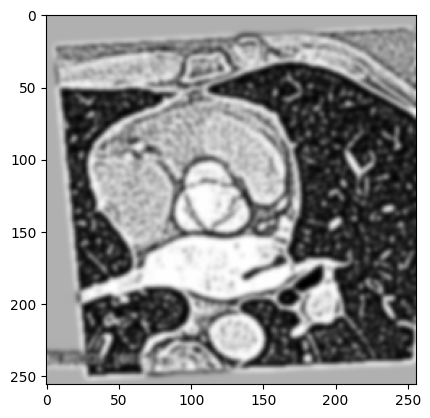

In [2]:
'''
PRIMERA CAPA DE PREPROCESAMIENTO
    1) QUITAR EL FONDO NEGRO DE LA IMAGEN (RECORTE)
    2) AJUSTAR EL TAMANO DE LA IMAGEN (RESIZE)
'''

images = []

for filename in listdir('data/train/'):
    #img=img_as_float(io.imread(f'data/{filename}'))
    img = cv2.imread(f'data/train/{filename}',0, )
    img = img[:, 174:550] #recorte de imagen
    img = cv2.resize(img, [256,256])    
    
    img = cv2.convertScaleAbs(img, alpha=1.1, beta=-1)  #alpha contrast   - beta = brightness
    img = unsharp_mask(img, radius=1, amount=50)
    img = gaussian(img, sigma=(1.6,1.6), truncate=3.8, channel_axis=2)
    img = np.trunc(img * 255)
    img = np.array(img, dtype=np.int64)
    images.append(img)


print(images[1].shape)
plt.imshow(images[1], cmap='gray')

In [3]:
def gen_superpixels(image, numSegments = 110, sigma=3.5): 
    segments = slic(image, n_segments = numSegments, sigma = sigma, compactness=0.1)
    image_superpixels = mark_boundaries(image, segments)
    

    return image_superpixels,segments

In [4]:
superpixels_images = [] 
image_segments = []

for img in images :
    sp, segment = gen_superpixels(img)
    superpixels_images.append(sp)
    image_segments.append(segment)

In [5]:
images[0]

array([[162, 162, 162, ..., 182, 146,  91],
       [162, 162, 162, ..., 182, 146,  91],
       [162, 162, 162, ..., 182, 146,  91],
       ...,
       [169, 169, 169, ..., 124,  91,  55],
       [164, 164, 164, ..., 125, 100,  64],
       [162, 162, 162, ..., 115, 101,  68]], dtype=int64)

In [6]:
superpixels_images[1]

array([[[1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        [1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        [1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        ...,
        [1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        [1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        [1.90819582e-17, 1.90819582e-17, 1.90819582e-17]],

       [[1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        [1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        [1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        ...,
        [1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        [1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        [1.90819582e-17, 1.90819582e-17, 1.90819582e-17]],

       [[1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        [1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        [1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        ...,
        [1.90819582e-17, 1.90819582e-17, 1.90819582e-17],
        [1.90819582e-17, 1.90

In [7]:
image_segments[1]

array([[  1,   1,   1, ...,   8,   8,   8],
       [  1,   1,   1, ...,   8,   8,   8],
       [  1,   1,   1, ...,   8,   8,   8],
       ...,
       [103, 103, 103, ..., 101, 101, 101],
       [103, 103, 103, ..., 101, 101, 101],
       [103, 103, 103, ..., 101, 101, 101]], dtype=int64)

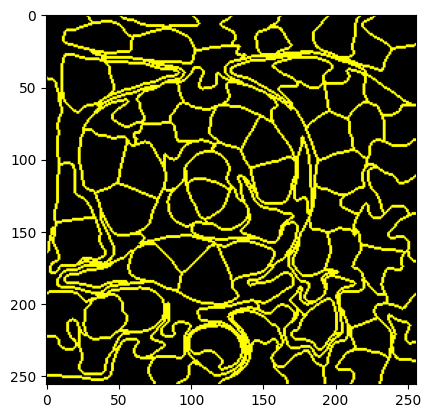

In [8]:
plt.imshow(superpixels_images[0])

In [9]:
def get_label(x,y, labels):
    return labels[y,x]

In [10]:
coords=[]
def click_event(event, x, y, flags, params):

    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:

        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)

        # displaying the coordinates
        # on the image window
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(superpixels_images[1], str(x) + ',' +
                    str(y), (x, y), font,
                    0.3, (0, 255, 0), 1)
        cv2.imshow('image', superpixels_images[1])

    # checking for right mouse clicks
    if event == cv2.EVENT_RBUTTONDOWN:

        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)

        # displaying the coordinates
        # on the image window
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(superpixels_images[1], str(get_label(x,y,image_segments[1])),
                    (x, y), font, 0.3,
                    (255, 0, 255), 1)
        cv2.imshow('image', superpixels_images[1])
        coords.append([x,y])
    


In [11]:
#cv2.imshow('image', superpixels_images[1])
#
## setting mouse handler for the image
## and calling the click_event() function
#
#cv2.setMouseCallback('image', click_event)
#
## wait for a key to be pressed to exit
#cv2.waitKey(0)
#
## close the window
#cv2.destroyAllWindows()

In [12]:
images[1]

array([[176, 176, 176, ..., 176, 176, 176],
       [176, 176, 176, ..., 176, 176, 176],
       [176, 176, 176, ..., 176, 176, 176],
       ...,
       [176, 176, 176, ..., 176, 176, 176],
       [176, 176, 176, ..., 176, 176, 176],
       [176, 176, 176, ..., 176, 176, 176]], dtype=int64)

In [13]:
def createMasks(image, segment, coords):
    mask = np.zeros(image.shape, dtype = "uint8")
    
    for label in coords: 
        mask[segment == label] = 255

    masked_image = cv2.bitwise_and(image, image, mask = mask)
    return masked_image


In [14]:
X_train = [] 
img_coords = [[47,53,55,58], [49,54,56,57]]

for i in range(len(images)):
    mask = createMasks(images[i], image_segments[i], img_coords[i])
    X_train.append(mask)

X_train = np.array(X_train,dtype=np.uint8)

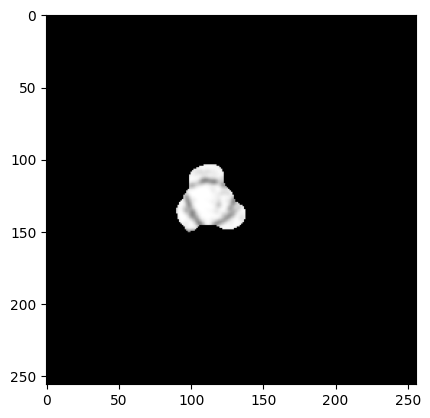

In [15]:
plt.imshow(X_train[1],cmap='gray')

PRUEBA CON DISTANCIAS ENTRE HISTOGRAMAS

In [16]:
def calcHistogram(img):   
    # get image dimensions so that we can loop over the entire image
    img_height = img.shape[0]
    img_width = img.shape[1]

    # initialize an array of 256 ints (all zero)
    # the index range for this list is [0, 255]
    histogram = np.zeros([256], np.int32) 
    
    # loop through each pixel in image
    for y in range(0, img_height):
        for x in range(0, img_width):
            # img[y,x] is the same as img[y][x]
            # it returns the grayscale value of the pixel at that position 
            # (which ranges from [0, 255])
            # we then use that grayscale value as the index for our histogram
            # and add one to that index
            # so histogram[0] represents the number of pixels with a grayscale value of 0
            histogram[img[y, x]] +=1
         
    return histogram

In [17]:
histograms = []

for mask in X_train: 
    histogram = cv2.calcHist([mask],[0],None,[256],[200,255])
    histograms.append(histogram)

len(histograms) 

2

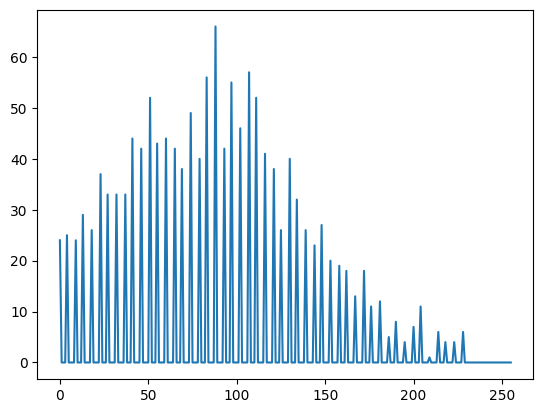

In [18]:
plt.plot(histograms[0])
plt.show()

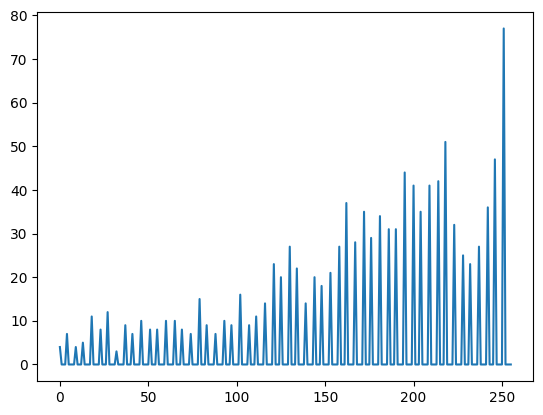

In [19]:
plt.plot(histograms[1])
plt.show()

In [20]:
histograms_mean = [(x1+x2)/2 for x1,x2 in zip(histograms[0], histograms[1])]
histograms_mean = np.array(histograms_mean)

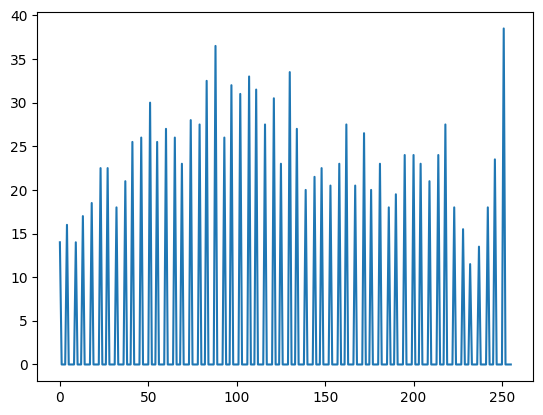

In [21]:
plt.plot(histograms_mean)
plt.show()

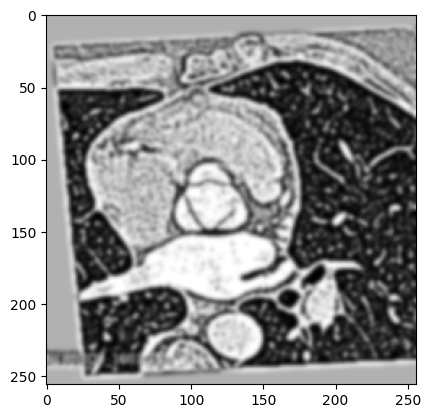

In [22]:
X_test = []
for filename in listdir('data/test'):
    #img=img_as_float(io.imread(f'data/{filename}'))
    img = cv2.imread(f'data/test/{filename}',0, )
    img = img[:, 174:550] #recorte de imagen
    img = cv2.resize(img, [256,256])    
    
    img = cv2.convertScaleAbs(img, alpha=1.1, beta=-1)  #alpha contrast   - beta = brightness
    img = unsharp_mask(img, radius=1, amount=50)
    img = gaussian(img, sigma=(1.5,1.5), truncate=3.5, channel_axis=2)
    img = np.trunc(img * 255)
    img = np.array(img, dtype=np.uint8)
    X_test.append(img)

X_test = np.array(X_test, dtype=np.uint8)
plt.imshow(X_test[0],cmap='gray')

In [23]:
superpixels_images_test = [] 
image_segment_test = []

for img in X_test :
    sp, segment = gen_superpixels(img)
    superpixels_images_test.append(sp)
    image_segment_test.append(segment)

In [24]:
image_segment_test[0].shape

(256, 256)

In [25]:
test_histograms = []

for i,segment in enumerate(image_segment_test):
	for (y, segVal) in enumerate(np.unique(segment)):
		if y < len(segment):
			mask = np.zeros(X_test[i].shape, dtype="uint8")
			mask[image_segment_test[i] == segVal] = 255
			temp_masked_image = cv2.bitwise_and(X_test[i], X_test[i], mask = mask)
			histogram = cv2.calcHist([temp_masked_image],[0],None,[256],[200,255])
			test_histograms.append(histogram)

test_histograms = np.array(test_histograms)
test_histograms.shape

(104, 256, 1)

In [26]:
histograms_mean.shape

(256, 1)

In [33]:
def chi2_distance(A, B):
    # compute the chi-squared distance using above formula
    chi = 0.5 * np.sum([((a - b) ** 2) / (a + b) for (a, b) in zip(A, B)])
    return chi

'''computing distance
se manejo la distancia de chi cuadrada

el numero en el que la distancia es igual es 0.0
'''

optimal_distances = [] #storage the labels 
for i in range(len(test_histograms) -1):
    chi2_distance = cv2.compareHist(histograms_mean, test_histograms[i], method=cv2.HISTCMP_CHISQR)

    bha_distance = cv2.compareHist(histograms_mean, test_histograms[i], method=cv2.HISTCMP_BHATTACHARYYA)
    
    corr_distance = cv2.compareHist(histograms_mean, test_histograms[i], method=cv2.HISTCMP_CORREL)


    if bha_distance <= 0.7: 
        optimal_distances.append(i)

print(optimal_distances)

[5, 11, 12, 14, 15, 16, 17, 18, 20, 27, 28, 30, 31, 32, 35, 36, 37, 42, 44, 45, 46, 48, 50, 53, 54, 58, 59, 60, 61, 67, 68, 69, 71, 73, 76, 78, 79, 80, 91, 93, 95, 97, 98]


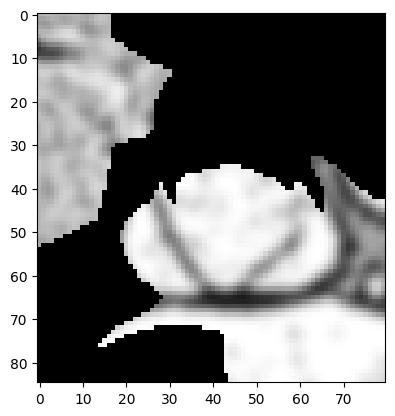

In [35]:
mask = createMasks(X_test[0], image_segment_test[0], optimal_distances)
mask = mask[85:170, 70:150]


plt.imshow(mask, cmap='gray')

PRUEBA CON MODELOS


In [29]:
def feature_extractor(data, set_name): 
    '''Esta funcion se encargara de la creacion de las matrices de GLCM2 y la extraccion de las caracteristicas de las mismas
    ademas de almacenar los resultados en un dataframe que se podra utilizar a continuación como la información de 
    entrenamiento

    Los calculos de GLCM que se usaran son: 

    distancia   |   grados
    5           |   0
    3           |   pi/4
    5           |   pi/2
    3           |   3pi/4
    5           |   pi
    3           |   5pi/4
    5           |   3pi/2
    3           |   7pi/4



    Parameters
    ----------
        * data [list] : set de imagenes
        * set_name [str] : nombra al set resultante entre entrenamiento o prueba
        
    Returns
    ----------
        * dataset [DataFrame] : Dataframe de la extraccion de caracteristicas de las matrices de GLCM2
'''
    dataset = pd.DataFrame() #definimos un dataframe (excel) para guardar las caracteristicas

    for image in data:
        #print(f'{i}    {image.shape}')
        row = pd.DataFrame()  #dataframe auxiliar para almacenar una fila
        
        #Metricas para la primera GLCM
        GLCM = graycomatrix(image, [5], [0])      
        GLCM_Energy = graycoprops(GLCM, 'energy')[0]
        row['energy1'] = GLCM_Energy
        GLCM_corr = graycoprops(GLCM, 'correlation')[0]
        row['correlation1'] = GLCM_corr
        GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]
        row['dissimilarity1'] = GLCM_diss
        GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]
        row['homogeneity1'] = GLCM_hom
        GLCM_contr = graycoprops(GLCM, 'contrast')[0]
        row['contrast1'] = GLCM_contr

        #Metricas para la segunda GLCM
        GLCM2 = graycomatrix(image, [3], [np.pi/4])      
        GLCM_Energy2 = graycoprops(GLCM2, 'energy')[0]
        row['energy2'] = GLCM_Energy2
        GLCM_corr2 = graycoprops(GLCM2, 'correlation')[0]
        row['correlation2'] = GLCM_corr2
        GLCM_diss2 = graycoprops(GLCM2, 'dissimilarity')[0]
        row['dissimilarity2'] = GLCM_diss2
        GLCM_hom2 = graycoprops(GLCM2, 'homogeneity')[0]
        row['homogeneity2'] = GLCM_hom2
        GLCM_contr2 = graycoprops(GLCM2, 'contrast')[0]
        row['contrast2'] = GLCM_contr2

        #Metricas para la tercera GLCM
        GLCM3 = graycomatrix(image, [5], [np.pi/2])      
        GLCM_Energy3 = graycoprops(GLCM3, 'energy')[0]
        row['energy3'] = GLCM_Energy3
        GLCM_corr3 = graycoprops(GLCM3, 'correlation')[0]
        row['correlation3'] = GLCM_corr3
        GLCM_diss3 = graycoprops(GLCM3, 'dissimilarity')[0]
        row['dissimilarity3'] = GLCM_diss3
        GLCM_hom3 = graycoprops(GLCM3, 'homogeneity')[0]
        row['homogeneity3'] = GLCM_hom3
        GLCM_contr3 = graycoprops(GLCM3, 'contrast')[0]
        row['contrast3'] = GLCM_contr3

        #Metricas para la cuarta GLCM
        GLCM4 = graycomatrix(image, [3], [3*np.pi/4])      
        GLCM_Energy4 = graycoprops(GLCM4, 'energy')[0]
        row['energy4'] = GLCM_Energy4
        GLCM_corr4 = graycoprops(GLCM4, 'correlation')[0]
        row['correlation4'] = GLCM_corr4
        GLCM_diss4 = graycoprops(GLCM4, 'dissimilarity')[0]
        row['dissimilarity4'] = GLCM_diss4
        GLCM_hom4 = graycoprops(GLCM4, 'homogeneity')[0]
        row['homogeneity4'] = GLCM_hom4
        GLCM_contr4 = graycoprops(GLCM4, 'contrast')[0]
        row['contrast4'] = GLCM_contr4

        #Metricas para la cuarta GLCM
        GLCM5 = graycomatrix(image, [5], [np.pi])      
        GLCM_Energy5 = graycoprops(GLCM5, 'energy')[0]
        row['energy5'] = GLCM_Energy5
        GLCM_corr5 = graycoprops(GLCM5, 'correlation')[0]
        row['correlation5'] = GLCM_corr5
        GLCM_diss5 = graycoprops(GLCM4, 'dissimilarity')[0]
        row['dissimilarity5'] = GLCM_diss5
        GLCM_hom5 = graycoprops(GLCM4, 'homogeneity')[0]
        row['homogeneity5'] = GLCM_hom5
        GLCM_contr5 = graycoprops(GLCM4, 'contrast')[0]
        row['contrast5'] = GLCM_contr5

        #Metricas para la cuarta GLCM
        GLCM6 = graycomatrix(image, [3], [5*np.pi/4])      
        GLCM_Energy6 = graycoprops(GLCM6, 'energy')[0]
        row['energy6'] = GLCM_Energy6
        GLCM_corr6 = graycoprops(GLCM6, 'correlation')[0]
        row['correlation6'] = GLCM_corr6
        GLCM_diss6 = graycoprops(GLCM6, 'dissimilarity')[0]
        row['dissimilarity6'] = GLCM_diss6
        GLCM_hom6 = graycoprops(GLCM6, 'homogeneity')[0]
        row['homogeneity6'] = GLCM_hom6
        GLCM_contr6 = graycoprops(GLCM6, 'contrast')[0]
        row['contrast6'] = GLCM_contr6

        #Metricas para la cuarta GLCM
        GLCM7 = graycomatrix(image, [5], [3*np.pi/2])      
        GLCM_Energy7 = graycoprops(GLCM7, 'energy')[0]
        row['energy7'] = GLCM_Energy7
        GLCM_corr7 = graycoprops(GLCM7, 'correlation')[0]
        row['correlation7'] = GLCM_corr7
        GLCM_diss7 = graycoprops(GLCM7, 'dissimilarity')[0]
        row['dissimilarity7'] = GLCM_diss7
        GLCM_hom7 = graycoprops(GLCM7, 'homogeneity')[0]
        row['homogeneity7'] = GLCM_hom7
        GLCM_contr7 = graycoprops(GLCM7, 'contrast')[0]
        row['contrast7'] = GLCM_contr7

        #Metricas para la cuarta GLCM
        GLCM8 = graycomatrix(image, [3], [7*np.pi/4])      
        GLCM_Energy8 = graycoprops(GLCM8, 'energy')[0]
        row['energy8'] = GLCM_Energy8
        GLCM_corr8 = graycoprops(GLCM8, 'correlation')[0]
        row['correlation8'] = GLCM_corr8
        GLCM_diss8 = graycoprops(GLCM8, 'dissimilarity')[0]
        row['dissimilarity8'] = GLCM_diss8
        GLCM_hom8 = graycoprops(GLCM8, 'homogeneity')[0]
        row['homogeneity8'] = GLCM_hom8
        GLCM_contr8 = graycoprops(GLCM8, 'contrast')[0]
        row['contrast8'] = GLCM_contr8

        dataset = pd.concat([dataset, row])
    
    dataset.to_csv(f'metrics_{set_name}.csv')
    
    return dataset 

In [30]:
train_features = feature_extractor(X_train, 'train')
train_features

,energy1,correlation1,dissimilarity1,homogeneity1,contrast1,energy2,correlation2,dissimilarity2,homogeneity2,contrast2,...,energy7,correlation7,dissimilarity7,homogeneity7,contrast7,energy8,correlation8,dissimilarity8,homogeneity8,contrast8
0,0.964782,0.832339,2.533522,0.966084,434.081175,0.966892,0.907756,1.531589,0.968522,237.889578,...,0.964767,0.834351,2.483628,0.966374,428.871763,0.966861,0.905295,1.573780,0.968730,244.238297
0,0.973155,0.814804,2.267306,0.974521,422.047996,0.974968,0.898051,1.332042,0.977677,231.420423,...,0.973280,0.821208,2.195873,0.975261,407.453499,0.974891,0.896748,1.362949,0.977364,234.377550
